In [1]:
import os, shutil, time

In [18]:
import tensorflow as tf
# this lines are to fix a problem with Conv2D and CUDA
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
original_dataset_dir = r'C:\Users\fdoli\github\DLpython\cats-vs-dogs-data-kaggle'

base_dir = r'C:\Users\fdoli\github\DLpython\cats-vs-dogs-data-kaggle\catdog_small'
#os.mkdir(base_dir)

We create the folder to split the original data into a train, a validation and a test set

In [4]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

We create the subfolder for cats and dogs

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

We copy the pictures of cats into the three folders

In [6]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'train\\' + fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'train\\' + fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'train\\' + fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

We copy the pictures of dogs now

In [7]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'train\\' + fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'train\\' + fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, 'train\\' + fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

We count the images in each folder

In [8]:
print('total training cat images: {}'.format(len(os.listdir(train_cats_dir))))
print('total training dog images: {}'.format(len(os.listdir(train_dogs_dir))))
print('total validation cat images: {}'.format(len(os.listdir(validation_cats_dir))))
print('total validation dog images: {}'.format(len(os.listdir(validation_dogs_dir))))
print('total test cat images: {}'.format(len(os.listdir(test_cats_dir))))
print('total test dog images: {}'.format(len(os.listdir(test_dogs_dir))))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


Now we can build the network

In [9]:
from keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For compilation, we use the `binary_crossentropy` loss function, since this is a binary classifier.

In [11]:
from keras import optimizers

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### Data preprocessing

As the input images are jpegs files, we need to convert them to tensors. We use keras utilities for that. We need to:
- Read the pictures
- Decode the JPEG info to RGB grids of pixels
- Convert the grids to floating-point tensors
- Rescale the pixel value to a range 0-1 (from 0-255)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

We create the data generators, in batches of 20 pictures

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
import PIL

In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape: {}'.format(data_batch.shape))
    print('labels batch shape: {}'.format(labels_batch.shape))
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


These are `150x150 px` RGB images (3 channels), in batches of 20 samples, as we defined it.  
Now, to fit the model we use the `fit_generator` method, since our data is in the generators. We give the generator as the first argument, and we have to specify the `steps_per_epoch` parameter to tell keras when to stop drawing batches of data and finish one epoch. As we have 2000 training images, we set it to `100` steps.

We can pass the validation data to the `validation_data` parameter. For that we also have to specify the number of steps until drawing the whole validatio dataset. 

In [17]:
start = time.perf_counter()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/30
100/100 [==============================] - 34s 340ms/step - loss: 0.6906 - acc: 0.5300 - val_loss: 0.6747 - val_acc: 0.5640
Epoch 2/30
100/100 [==============================] - 29s 286ms/step - loss: 0.6620 - acc: 0.6070 - val_loss: 0.6404 - val_acc: 0.6510
Epoch 3/30
100/100 [==============================] - 29s 287ms/step - loss: 0.6148 - acc: 0.6655 - val_loss: 0.6070 - val_acc: 0.6590
Epoch 4/30
100/100 [==============================] - 29s 291ms/step - loss: 0.5737 - acc: 0.6980 - val_loss: 0.5888 - val_acc: 0.6900
Epoch 5/30
100/100 [==============================] - 29s 290ms/step - loss: 0.5397 - acc: 0.7270 - val_loss: 0.5898 - val_acc: 0.6770
Epoch 6/30
100/100 [==============================] - 29s 290ms/step - loss: 0.5010 - acc: 0.7570 - val_loss: 0.5625 - val_acc: 0.7150
Epoch 7/30
100/100 [==============================] - 29s 289ms/step - loss: 0.4762 - acc: 0.7745 - val_loss: 0.5741 - val_acc: 0.7050
Epoch 8/30
100/100 [==============================] - 2

GPU 876.552 seconds.

Let's save the model

In [19]:
model.save('cat_and_dogs_small_1.h5')

Now, plot the loss and accuracy of the model over the training and validation data

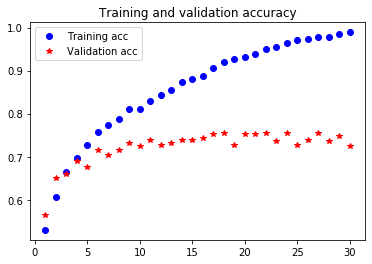

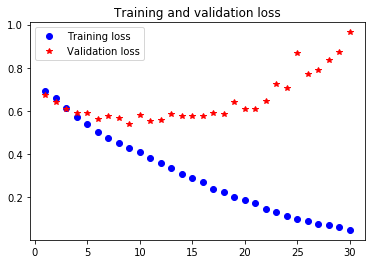

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These plots clearly show overfitting. Training curves improve continuously whereas validation curves stall. Because we have few samples (2000), overfitting is our concern. We should use regularization methods to help us with that problem. 

For this case, we'll use data augmentation. Let's start with an example:

In [22]:
datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest')

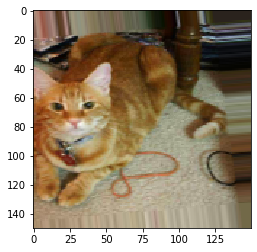

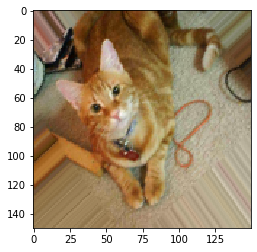

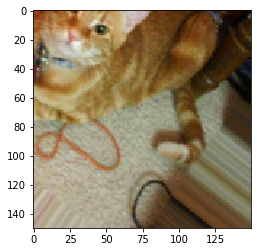

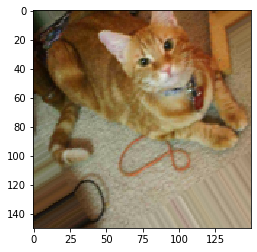

In [25]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[30] # choose one image to augment

img = image.load_img(img_path, target_size=(150, 150)) # readd the image and resize it

x = image.img_to_array(img) # converts it to a Numpy array with shape (150, 150, 3)
x = x.reshape((1, ) + x.shape) # reshape it to (1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

This is one way to have more training data for our model, and with that, reduce the overfitting of the model. Another method is to add Dropout to the model, right before the densely connected layer. Let's build a model again:

In [26]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Now we create the data generators, with augmentation:

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
start = time.perf_counter()

history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/30
100/100 [==============================] - 39s 395ms/step - loss: 0.5465 - acc: 0.7231 - val_loss: 0.5472 - val_acc: 0.7236
Epoch 2/30
100/100 [==============================] - 37s 371ms/step - loss: 0.5435 - acc: 0.7291 - val_loss: 0.5185 - val_acc: 0.7360
Epoch 3/30
100/100 [==============================] - 37s 371ms/step - loss: 0.5312 - acc: 0.7372 - val_loss: 0.5546 - val_acc: 0.7126
Epoch 4/30
100/100 [==============================] - 37s 373ms/step - loss: 0.5402 - acc: 0.7247 - val_loss: 0.5469 - val_acc: 0.7113
Epoch 5/30
100/100 [==============================] - 37s 372ms/step - loss: 0.5246 - acc: 0.7366 - val_loss: 0.5286 - val_acc: 0.7398
Epoch 6/30
100/100 [==============================] - 37s 373ms/step - loss: 0.5313 - acc: 0.7269 - val_loss: 0.5851 - val_acc: 0.6978
Epoch 7/30
100/100 [==============================] - 37s 371ms/step - loss: 0.5263 - acc: 0.7300 - val_loss: 0.5943 - val_acc: 0.7069
Epoch 8/30
100/100 [==============================] - 3

GPU: 1124.751 seconds

In [32]:
model.save('cat_and_dogs_small_2.h5')

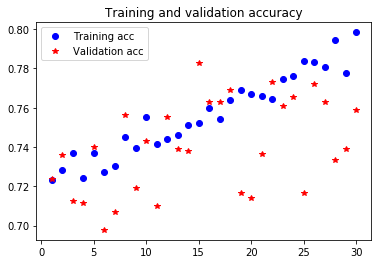

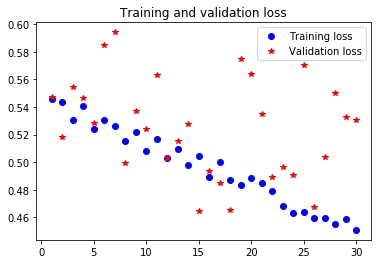

In [33]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It's much slower than the previous model (without augmentation and dropout). It looks better as the validation data goes along the training data but much noisier. 

I should run this model in a much more powerful machine for training it for more epochs  